In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

from src.configs import BallEncoder, BallDecoder, BallTransition
from src.e2c import E2C, compute_loss

### Method to create (3,32,32) tensor

In [3]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

### PWA single integrator kinematics

In [4]:
def step(x0, Ak, add_noise=False):
    # If ball in left-half plane, flip sign of vx
    if x0[0] < 0.5*posbounds[1]:
        x0[2] *= -1.

    update = Ak @ x0
    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)
    return update

### Generate training data

In [5]:
n = 4 
dh = 0.1

posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 32
NUM_DATA = 500

X = np.zeros((NUM_DATA,3,W,W))
X_next = np.zeros((NUM_DATA,3,W,W))

count = 0
while count < NUM_DATA:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X[count,:,:,:] = img
    X_next[count,:,:,:] = img_new

    count += 1

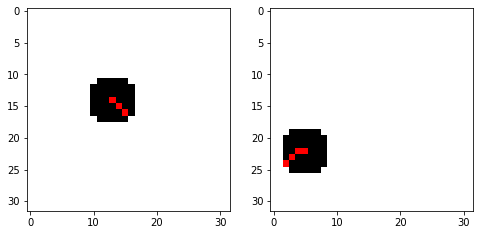

In [6]:
idx = 1
img, img_next = X[idx], X_next[idx]

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(img_next.transpose(1,2,0))

### Construct encoder/decoder

In [7]:
dim_in = X[0].shape
dim_z = 6
dim_u = 0

In [8]:
gpu = 0
model = E2C(dim_in, dim_z, dim_u, config='ball')
model.to(gpu);

In [9]:
# inp = torch.from_numpy(X[:2]).float().to(gpu)
# mean, logvar = model.encode(inp)
# model.decode(mean).shape

# before = torch.from_numpy(X[:2]).float().to(gpu)
# after = torch.from_numpy(X_next[:2]).float().to(gpu)
# ctrl = torch.empty(NUM_DATA, dim_u).to(gpu)

# model.forward(before, ctrl, after);

## Training loop

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# training parameters
TRAINING_ITERATIONS = int(10000)
BATCH_SIZE = int(32)
CHECKPOINT_AFTER = int(1500)
SAVEPOINT_AFTER = int(1000)
TEST_BATCH_SIZE = int(128)

rand_idx = list(np.arange(0, X_next.shape[0]-1))
indices = [rand_idx[ii * BATCH_SIZE:(ii + 1) * BATCH_SIZE] \
    for ii in range((len(rand_idx) + BATCH_SIZE - 1)     // BATCH_SIZE)]
if len(indices[-1]) == 1:
    # make sure batch doesn't just have one data point
    indices[-1].append(indices[-1][0])

itr = 1
for epoch in range(TRAINING_ITERATIONS):
    for ii, idx in enumerate(indices):
        optimizer.zero_grad()

        before = torch.from_numpy(X[idx]).float().to(gpu)
        ctrl = torch.empty(len(idx), dim_u).to(gpu)
        after = torch.from_numpy(X_next[idx]).float().to(gpu)
#         after = np.copy(X[idx])
#         for jj in range(len(idx)):
#             after[jj,:,:,:] = X[0]
#         after = torch.from_numpy(after).float().to(gpu)

        next_pre_rec = model(before, ctrl, after)

        loss_rec, loss_trans = compute_loss(\
            model.x_dec, model.x_next_pred_dec, \
            before, after, \
            model.Qz, model.Qz_next_pred, model.Qz_next)

        loss = loss_rec # + loss_trans
        loss.backward()
        optimizer.step()

        if itr % CHECKPOINT_AFTER == 0:
            rand_idx = list(np.arange(0, X.shape[0]))
            random.shuffle(rand_idx)
            test_idx = rand_idx[:TEST_BATCH_SIZE]
            before = torch.from_numpy(X[test_idx]).float().to(gpu)
            ctrl = torch.empty(len(test_idx), dim_u).to(gpu)
            after = torch.from_numpy(X_next[test_idx]).float().to(gpu)
            next_pre_rec = model.predict(before, ctrl)
            x_next_reconst_loss = (after - next_pre_rec).pow(2).sum(dim=1).mean().detach().cpu().numpy()
#             x_reconst = model.decoder.eval()(model.encoder.eval()(before)[0])
#             x_reconst_loss = (before - x_reconst).pow(2).sum(dim=1).mean().detach().cpu().numpy()
            print('Average reconstruction loss: {}'.format(x_next_reconst_loss))

            fig = plt.figure(figsize=(8,8))
            fig.add_subplot(1,3,1)
            rando_idx = np.random.randint(0,TEST_BATCH_SIZE)
            plt.imshow(before[rando_idx,:,:,:].cpu().detach().numpy().transpose(1,2,0))
            fig.add_subplot(1,3,2)
            plt.imshow(after[rando_idx,:,:,:].cpu().detach().numpy().transpose(1,2,0))
            fig.add_subplot(1,3,3)
#             img_reconstruct = x_reconst[rando_idx,:,:,:].cpu().detach().numpy()
            img_reconstruct = next_pre_rec[rando_idx,:,:,:].cpu().detach().numpy()
            img_reconstruct = np.minimum(img_reconstruct, 1.)  # saturate pixel values to [0,1]
            img_reconstruct = np.maximum(img_reconstruct, 0.)
            plt.imshow(img_reconstruct.transpose(1,2,0))

            dir_name = 'reconst_img'
            if not os.path.exists(dir_name):
                os.makedirs(dir_name)
            plt.savefig('{}/{}.png'.format(dir_name,itr))
            plt.close()

        if itr % SAVEPOINT_AFTER == 0:
            fn_pt_model = "./dump.pt"
#             torch.save(model.state_dict(), fn_pt_model)
#             print("Saved model at {}".format(fn_pt_model))

        itr += 1

#         print('loss_rec:{}, loss_trans:{}'.format(loss_rec.item(), loss_trans.item()))

Average reconstruction loss: 0.1284363567829132
Average reconstruction loss: 0.1266273409128189
Average reconstruction loss: 0.12596504390239716
Average reconstruction loss: 0.11259845644235611
Average reconstruction loss: 0.12412288039922714
Average reconstruction loss: 0.1151428073644638
Average reconstruction loss: 0.11327555775642395
Average reconstruction loss: 0.11679643392562866
Average reconstruction loss: 0.12270402908325195
Average reconstruction loss: 0.122612863779068
Average reconstruction loss: 0.12264701724052429
Average reconstruction loss: 0.12260034680366516
Average reconstruction loss: 0.11205693334341049
Average reconstruction loss: 0.1226540207862854
Average reconstruction loss: 0.11260849237442017
Average reconstruction loss: 0.11186175793409348
Average reconstruction loss: 0.11168314516544342
Average reconstruction loss: 0.1226535439491272
Average reconstruction loss: 0.11080261319875717
Average reconstruction loss: 0.1123003140091896
Average reconstruction loss:

KeyboardInterrupt: 

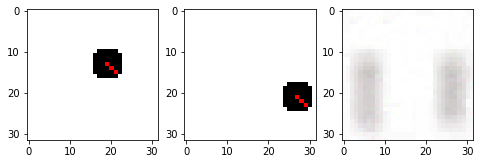

In [27]:
# Generate some random dummy image
img_inp, img_next = None, None
while img_inp is None or img_next is None:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))
    img_inp = create_img(x0, posbounds)
    x0_new = step(x0, Ak)
    img_next = create_img(x0_new, posbounds)
    
X_rand = np.zeros((2,3,W,W))
X_rand[0,:,:,:] = img_inp

before = torch.from_numpy(X_rand).float().to(gpu)
# img_reconstruct = model.decoder.eval()(model.encoder.eval()(before)[0])[overfit_idx,:,:,:].detach().cpu().numpy()
ctrl = torch.empty(len(test_idx), dim_u).to(gpu)
next_pre_rec = model.predict(before, ctrl)

img_reconstruct = next_pre_rec[0].cpu().detach().numpy()
img_reconstruct = np.minimum(img_reconstruct, 1.)  # saturate pixel values to [0,1]
img_reconstruct = np.maximum(img_reconstruct, 0.)

fig = plt.figure(figsize=(8,8))
 
# Input image
fig.add_subplot(1,3,1)
plt.imshow(img_inp.transpose(1,2,0))

# "True" image that was overfit to
fig.add_subplot(1,3,2)
plt.imshow(img_next.transpose(1,2,0))

fig.add_subplot(1,3,3)
plt.imshow(img_reconstruct.transpose(1,2,0))

In [ ]:
# from IPython import display
# import matplotlib.pyplot as plt

# %matplotlib inline

# import gym
# from gym import wrappers

# env = gym.make('CartPole-v0')
# # env = wrappers.Monitor(env, "./gym-results", force=True)
# env.reset()

# # plt.figure(figsize=(9,9))
# # img = plt.imshow(env.render(mode='rgb_array')) # only call this once

# for _ in range(10):
# #     img.set_data(env.render(mode='rgb_array')) # just update the data
# #     display.display(plt.gcf())
# #     display.clear_output(wait=True)

#     obs, reward, done, info = env.step(env.action_space.sample())
# #     env.render()
#     if done:
#         env.reset()

# env.close()